<a href="https://colab.research.google.com/github/Am1rTl/Info/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **## 1) Характеристики набора данных**

В наборе данных представлены точки в декартовой системе координат.

| Характеристика | Описание                   |
| :------------- | :------------------------- |
| X              | Координата Х точки.        |
| Y              | Координата Y точки.        |

### **## 2) Задание**

Выполнить и сравнить несколько алгоритмов кластерного анализа, выделив их в виде переиспользуемых функций. Продемонстрировать промежуточные шаги работы алгоритмов.

### **## 3) Загрузка и предварительный анализ данных**

На этом этапе мы загрузим (сгенерируем) данные, изучим их структуру и визуализируем, чтобы составить первичное представление.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (10, 7)

Первые 5 строк первого набора данных:
          X         Y
0  4.630081  1.255366
1  1.950512  5.313545
2  0.998057  4.859417
3  2.046865  1.153660
4 -8.376261 -7.161320


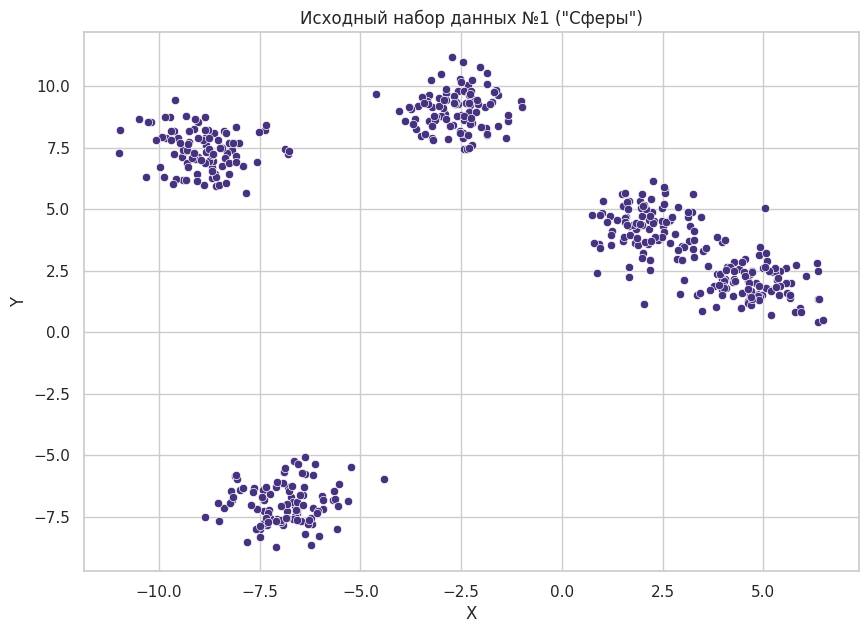

In [23]:
X1, y1 = make_blobs(n_samples=500, centers=5, cluster_std=0.8, random_state=42)
df1 = pd.DataFrame(X1, columns=['X', 'Y'])
print("Первые 5 строк первого набора данных:")
print(df1.head())
sns.scatterplot(data=df1, x='X', y='Y')
plt.title('Исходный набор данных №1 ("Сферы")')
plt.show()

### **## 4) Подготовка данных (Нормализация)**

Нормализуем данные, чтобы все признаки находились в одном диапазоне (от 0 до 1). Это общий шаг для всех алгоритмов.

In [24]:
scaler1 = MinMaxScaler()
df1_normalized = pd.DataFrame(scaler1.fit_transform(df1), columns=df1.columns)
print("Нормализованные данные №1 (первые 5 строк):")
print(df1_normalized.head())

Нормализованные данные №1 (первые 5 строк):
          X         Y
0  0.893551  0.501054
1  0.740323  0.704859
2  0.685858  0.682052
3  0.745832  0.495946
4  0.149798  0.078361


### **## 5) Описание и определение функций для алгоритмов кластеризации**

#### **Алгоритм 1: K-Means**
Алгоритм K-Means — это метод кластеризации, который разделяет данные на K кластеров. Он итеративно находит центры кластеров и относит каждую точку данных к ближайшему центру.

#### **Алгоритм 2: Рост регионов из самых плотных областей**
Основной принцип такой, что данные визуализируются на плоскости, а потом разбиваются по квадратикам. Из вершины (пика плотности) берутся те квадратики, в которых находится больше всего точек. Далее, так как мы знаем, что между обычными данными и данными, которые находятся в этом кластере, есть большая разница, мы можем двигаться вправо и влево по этим данным, пока не увидим резкий скачок на графике в разности между клеточками.

#### **Алгоритм 3: Градиентный метод слияния**
Этот алгоритм является улучшенной версией второго. Изначально мы берём много вершин (пиков), которые постепенно, при движении по клеточкам, сливаются в одни, если они находятся рядом. Это позволяет более гибко определять границы кластеров.

In [25]:
def run_kmeans(df_norm, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_norm)
    return labels

def run_region_growing(df_norm, grid_size=50, density_threshold=5):
    grid, x_edges, y_edges = np.histogram2d(df_norm['X'], df_norm['Y'], bins=grid_size)
    peak_indices = np.argwhere(grid > density_threshold)
    labels_grid = -np.ones_like(grid, dtype=int)
    cluster_id_counter = 0
    for start_node in peak_indices:
        start_node = tuple(start_node)
        if labels_grid[start_node] != -1:
            continue
        current_cluster_id = cluster_id_counter
        q = deque([start_node])
        labels_grid[start_node] = current_cluster_id
        while q:
            px, py = q.popleft()
            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                nx, ny = px + dx, py + dy
                if 0 <= nx < grid_size and 0 <= ny < grid_size and labels_grid[nx, ny] == -1 and grid[nx, ny] > 0:
                    labels_grid[nx, ny] = current_cluster_id
                    q.append((nx, ny))
        cluster_id_counter += 1
    x_bins = np.digitize(df_norm['X'], x_edges)
    y_bins = np.digitize(df_norm['Y'], y_edges)
    x_bins[x_bins > grid_size] = grid_size
    y_bins[y_bins > grid_size] = grid_size
    final_labels = labels_grid[x_bins - 1, y_bins - 1]
    return final_labels, grid, peak_indices

def run_gradient_method(df_norm, grid_size=50, n_peaks=15, gradient_threshold=0.7):
    grid, x_edges, y_edges = np.histogram2d(df_norm['X'], df_norm['Y'], bins=grid_size)
    flat_indices = np.argsort(grid.flatten())[-n_peaks:]
    peak_indices = np.unravel_index(flat_indices, grid.shape)
    peak_indices = list(zip(peak_indices[0], peak_indices[1]))
    labels_grid = -np.ones_like(grid, dtype=int)
    cluster_id_map = {}
    cluster_id_counter = 0
    for start_node in peak_indices:
        if labels_grid[start_node] != -1:
            continue
        current_cluster_id = cluster_id_counter
        cluster_id_map[current_cluster_id] = current_cluster_id
        q = deque([start_node])
        labels_grid[start_node] = current_cluster_id
        while q:
            px, py = q.popleft()
            current_density = grid[px, py]
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nx, ny = px + dx, py + dy
                if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx,ny] > 0:
                    neighbor_density = grid[nx,ny]
                    if (current_density - neighbor_density) / current_density < gradient_threshold:
                        if labels_grid[nx, ny] == -1:
                            labels_grid[nx, ny] = current_cluster_id
                            q.append((nx, ny))
                        else:
                            neighbor_cluster_id = labels_grid[nx, ny]
                            root_current = cluster_id_map[current_cluster_id]
                            root_neighbor = cluster_id_map[neighbor_cluster_id]
                            if root_current != root_neighbor:
                                min_id, max_id = min(root_current, root_neighbor), max(root_current, root_neighbor)
                                for k, v in cluster_id_map.items():
                                    if v == max_id: cluster_id_map[k] = min_id
        cluster_id_counter += 1
    for x in range(grid_size):
        for y in range(grid_size):
            if labels_grid[x, y] != -1:
                labels_grid[x, y] = cluster_id_map[labels_grid[x, y]]
    x_bins = np.digitize(df_norm['X'], x_edges)
    y_bins = np.digitize(df_norm['Y'], y_edges)
    x_bins[x_bins > grid_size] = grid_size
    y_bins[y_bins > grid_size] = grid_size
    final_labels = labels_grid[x_bins - 1, y_bins - 1]
    return final_labels, grid, peak_indices

### **## 6) Применение алгоритмов к набору данных №1 ("Сферы")**

#### **### 6.1) Алгоритм K-Means**

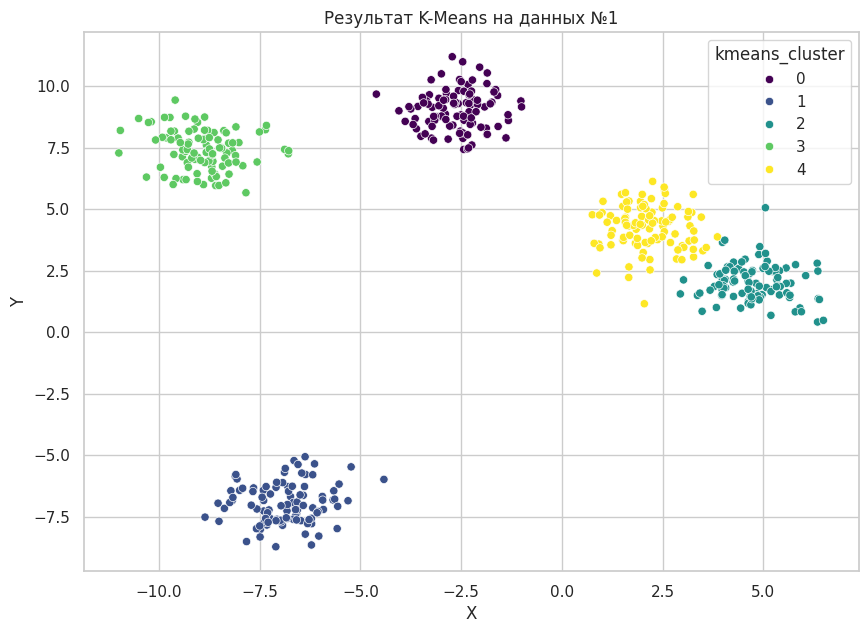

In [26]:
df1['kmeans_cluster'] = run_kmeans(df1_normalized, n_clusters=5)
sns.scatterplot(data=df1, x='X', y='Y', hue='kmeans_cluster', palette='viridis')
plt.title('Результат K-Means на данных №1')
plt.show()

#### **### 6.2) Экспериментальный алгоритм №1: Рост регионов**

In [27]:
labels, grid, peaks = run_region_growing(df1_normalized, density_threshold=3)
df1['region_cluster'] = labels

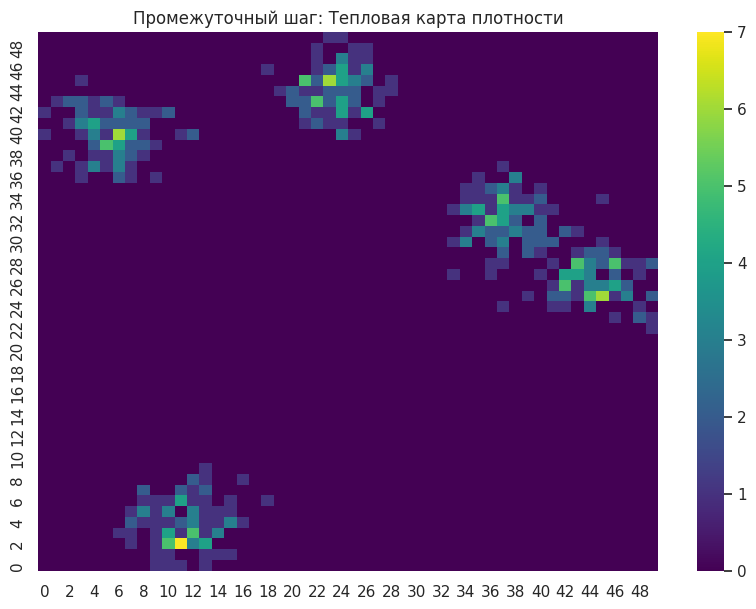

In [28]:
plt.figure(figsize=(10, 7))
sns.heatmap(grid.T, cmap="viridis").invert_yaxis()
plt.title('Промежуточный шаг: Тепловая карта плотности')
plt.show()

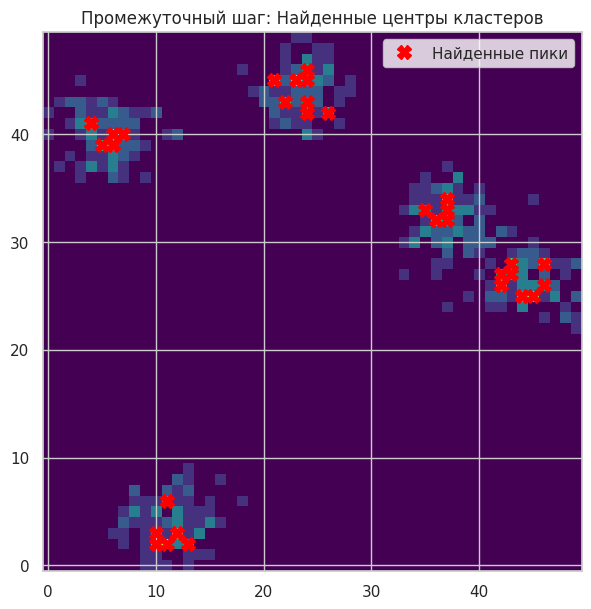

In [29]:
plt.figure(figsize=(10, 7))
plt.imshow(grid.T, cmap='viridis', origin='lower')
plt.plot(peaks[:, 0], peaks[:, 1], 'rX', markersize=10, label='Найденные пики')
plt.title('Промежуточный шаг: Найденные центры кластеров')
plt.legend()
plt.show()

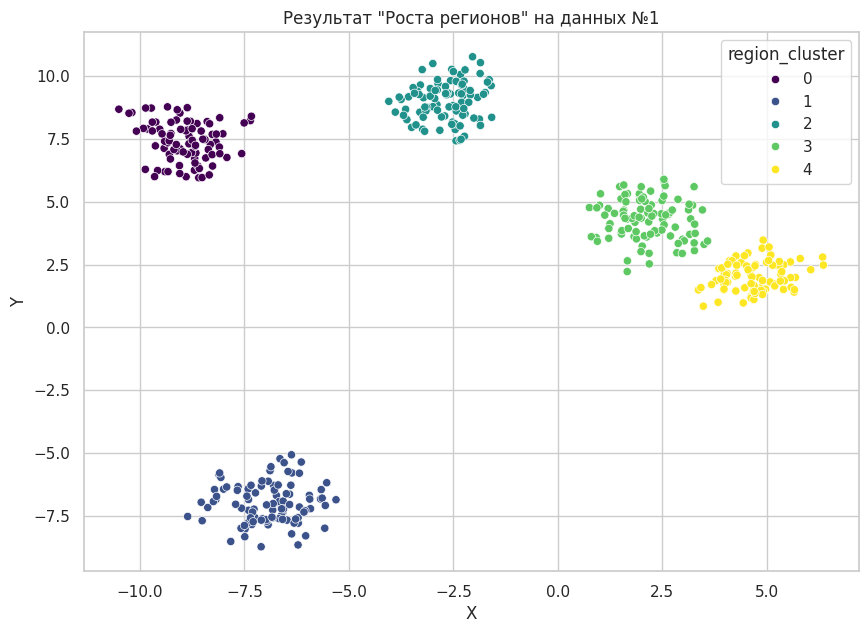

In [30]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df1[df1['region_cluster'] != -1], x='X', y='Y', hue='region_cluster', palette='viridis')
plt.title('Результат "Роста регионов" на данных №1')
plt.show()

#### **### 6.3) Экспериментальный алгоритм №2: Градиентный метод**

In [31]:
labels, grid, peaks = run_gradient_method(df1_normalized)
df1['gradient_cluster'] = labels

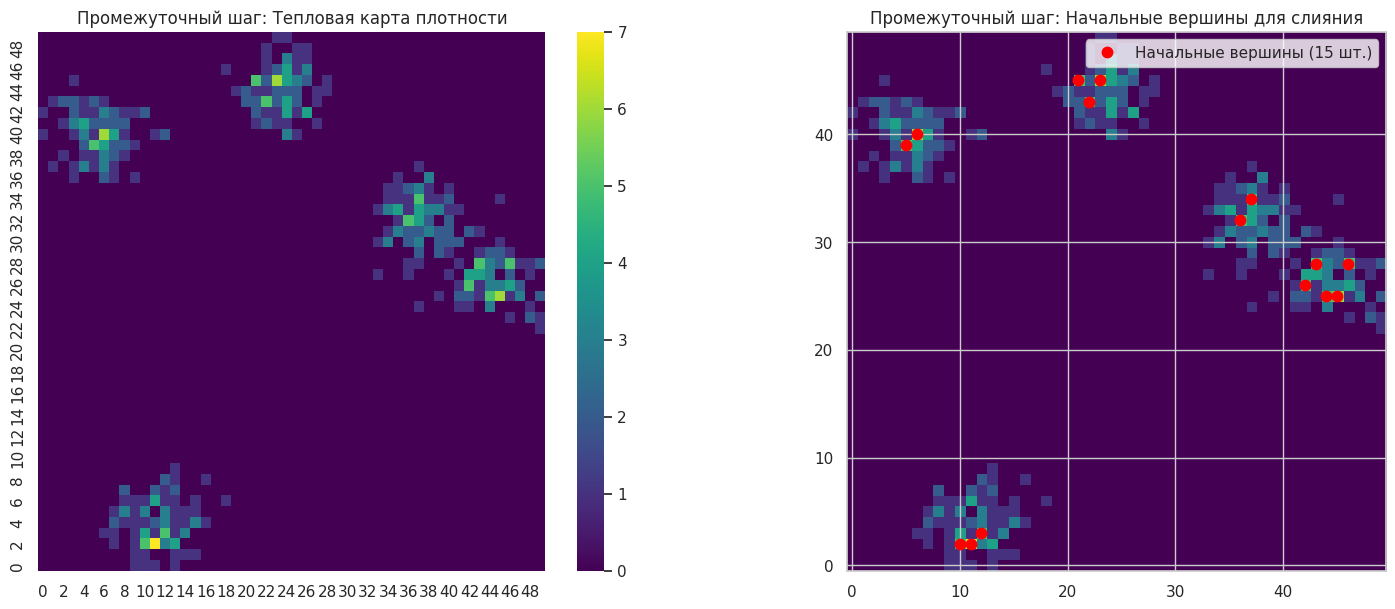

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(grid.T, ax=axes[0], cmap="viridis").invert_yaxis()
axes[0].set_title('Промежуточный шаг: Тепловая карта плотности')
axes[1].imshow(grid.T, cmap='viridis', origin='lower')
peak_x, peak_y = zip(*peaks)
axes[1].plot(peak_x, peak_y, 'r.', markersize=15, label='Начальные вершины (15 шт.)')
axes[1].set_title('Промежуточный шаг: Начальные вершины для слияния')
axes[1].legend()
plt.show()

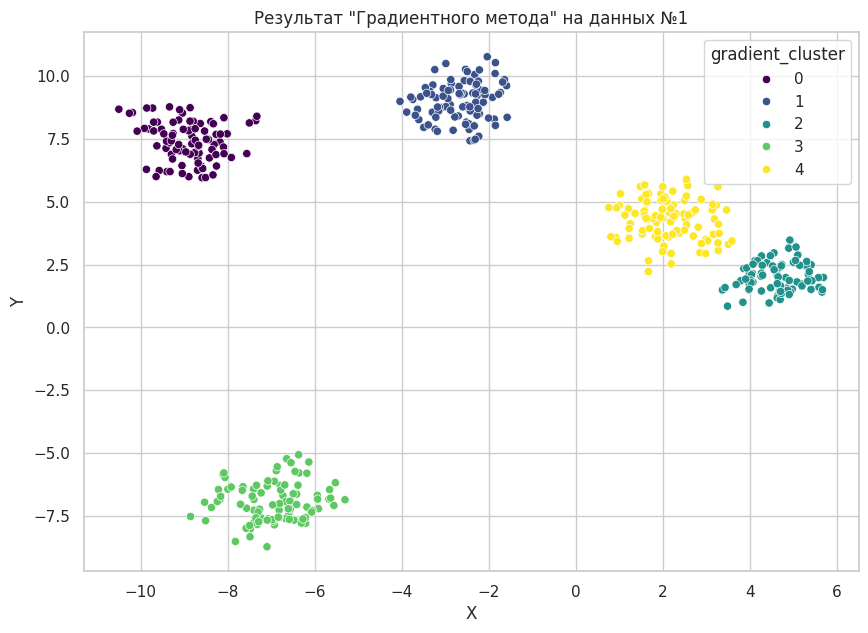

In [33]:
sns.scatterplot(data=df1[df1['gradient_cluster'] != -1], x='X', y='Y', hue='gradient_cluster', palette='viridis')
plt.title('Результат "Градиентного метода" на данных №1')
plt.show()

### Сравниваем все три результата

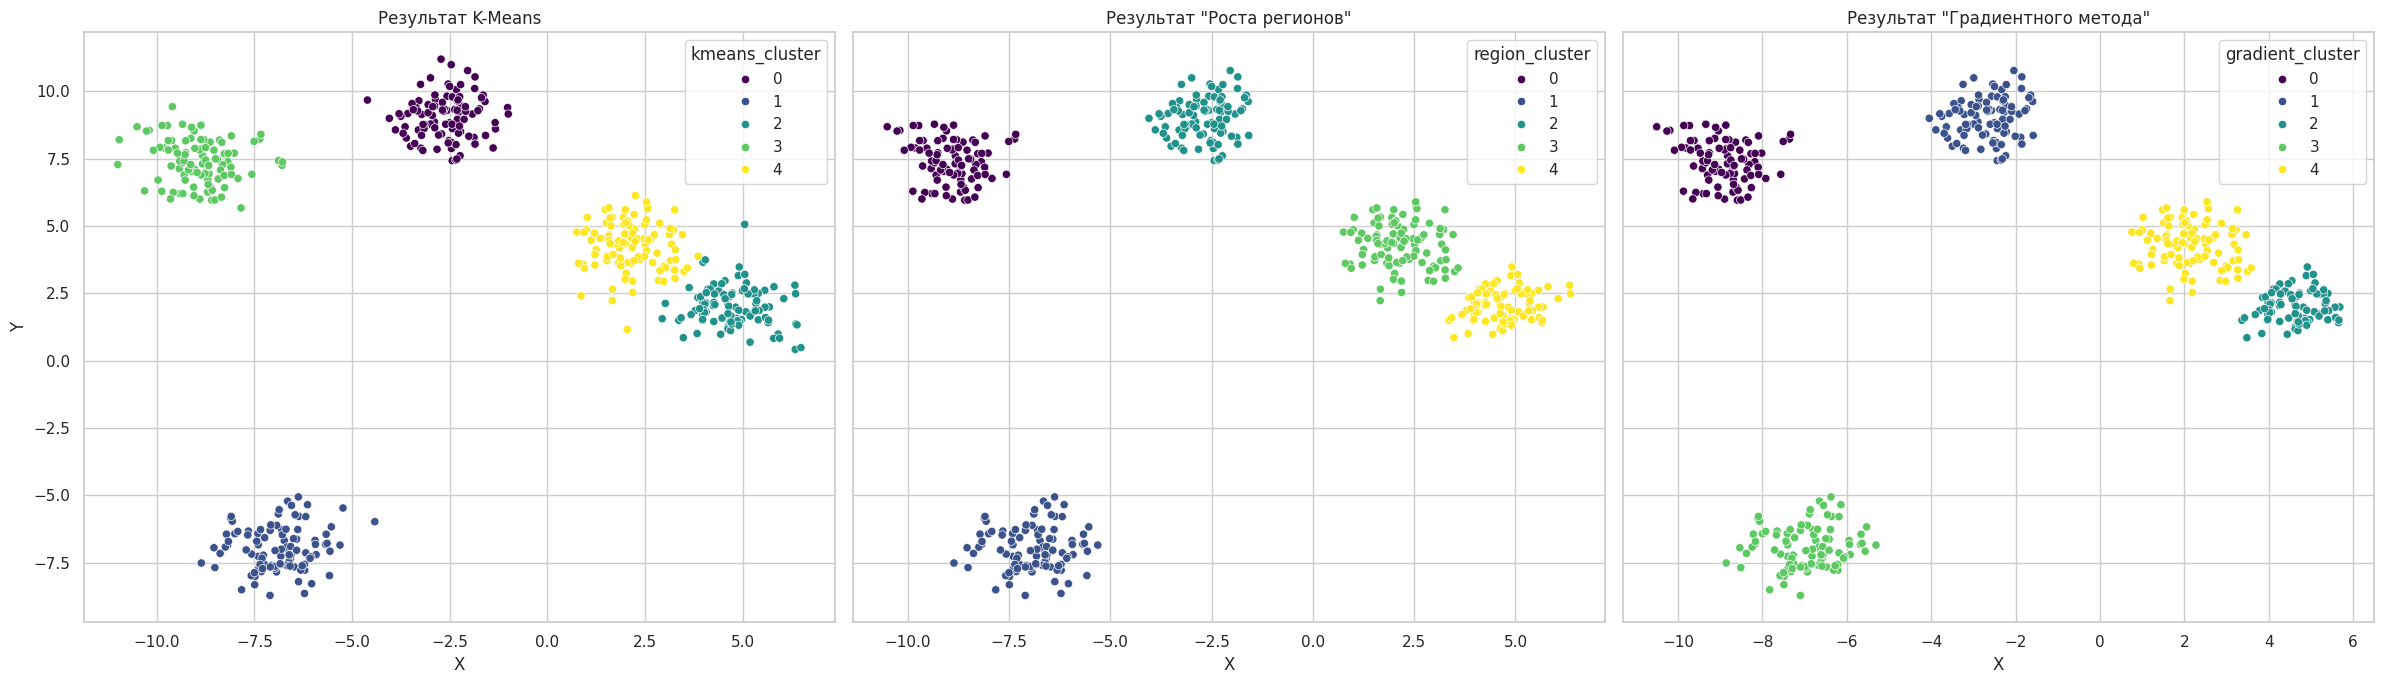

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)

sns.scatterplot(data=df1, x='X', y='Y', hue='kmeans_cluster', palette='viridis', ax=axes[0], legend='full')
axes[0].set_title('Результат K-Means')

sns.scatterplot(data=df1[df1['region_cluster'] != -1], x='X', y='Y', hue='region_cluster', palette='viridis', ax=axes[1], legend='full')
axes[1].set_title('Результат "Роста регионов"')

sns.scatterplot(data=df1[df1['gradient_cluster'] != -1], x='X', y='Y', hue='gradient_cluster', palette='viridis', ax=axes[2], legend='full')
axes[2].set_title('Результат "Градиентного метода"')

plt.tight_layout()
plt.show()

Первые 5 строк второго набора данных:
          X         Y
0  0.374693 -0.166804
1 -0.842344  0.118989
2  0.439100  0.838473
3 -0.925517  0.149781
4 -0.945743  0.327583


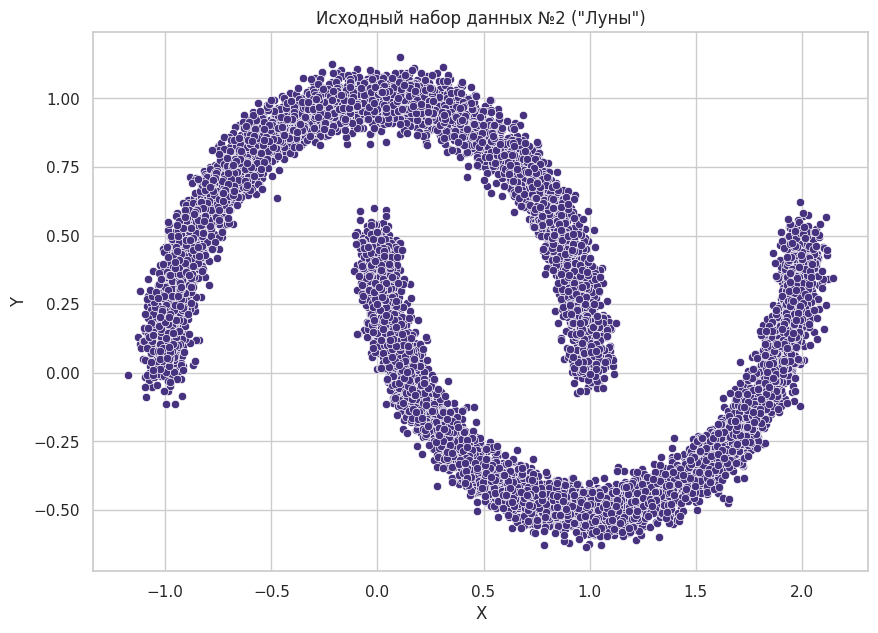

In [35]:
X2, y2 = make_moons(n_samples=10000, noise=0.05, random_state=42)
df2 = pd.DataFrame(X2, columns=['X', 'Y'])
print("Первые 5 строк второго набора данных:")
print(df2.head())
sns.scatterplot(data=df2, x='X', y='Y')
plt.title('Исходный набор данных №2 ("Луны")')
plt.show()

## Нормализация данных



In [36]:
scaler2 = MinMaxScaler()
df2_normalized = pd.DataFrame(scaler2.fit_transform(df2), columns=df2.columns)
print("Нормализованные данные №2 (первые 5 строк):")
print(df2_normalized.head())

Нормализованные данные №2 (первые 5 строк):
          X         Y
0  0.466191  0.261609
1  0.099669  0.421700
2  0.485588  0.824728
3  0.074621  0.438949
4  0.068529  0.538547


## Применение алгоритмов



In [37]:
df2['kmeans_cluster'] = run_kmeans(df2_normalized, n_clusters=2)
labels_region, grid_region, peaks_region = run_region_growing(df2_normalized)
df2['region_cluster'] = labels_region
labels_gradient, grid_gradient, peaks_gradient = run_gradient_method(df2_normalized)
df2['gradient_cluster'] = labels_gradient

## Визуализация результатов


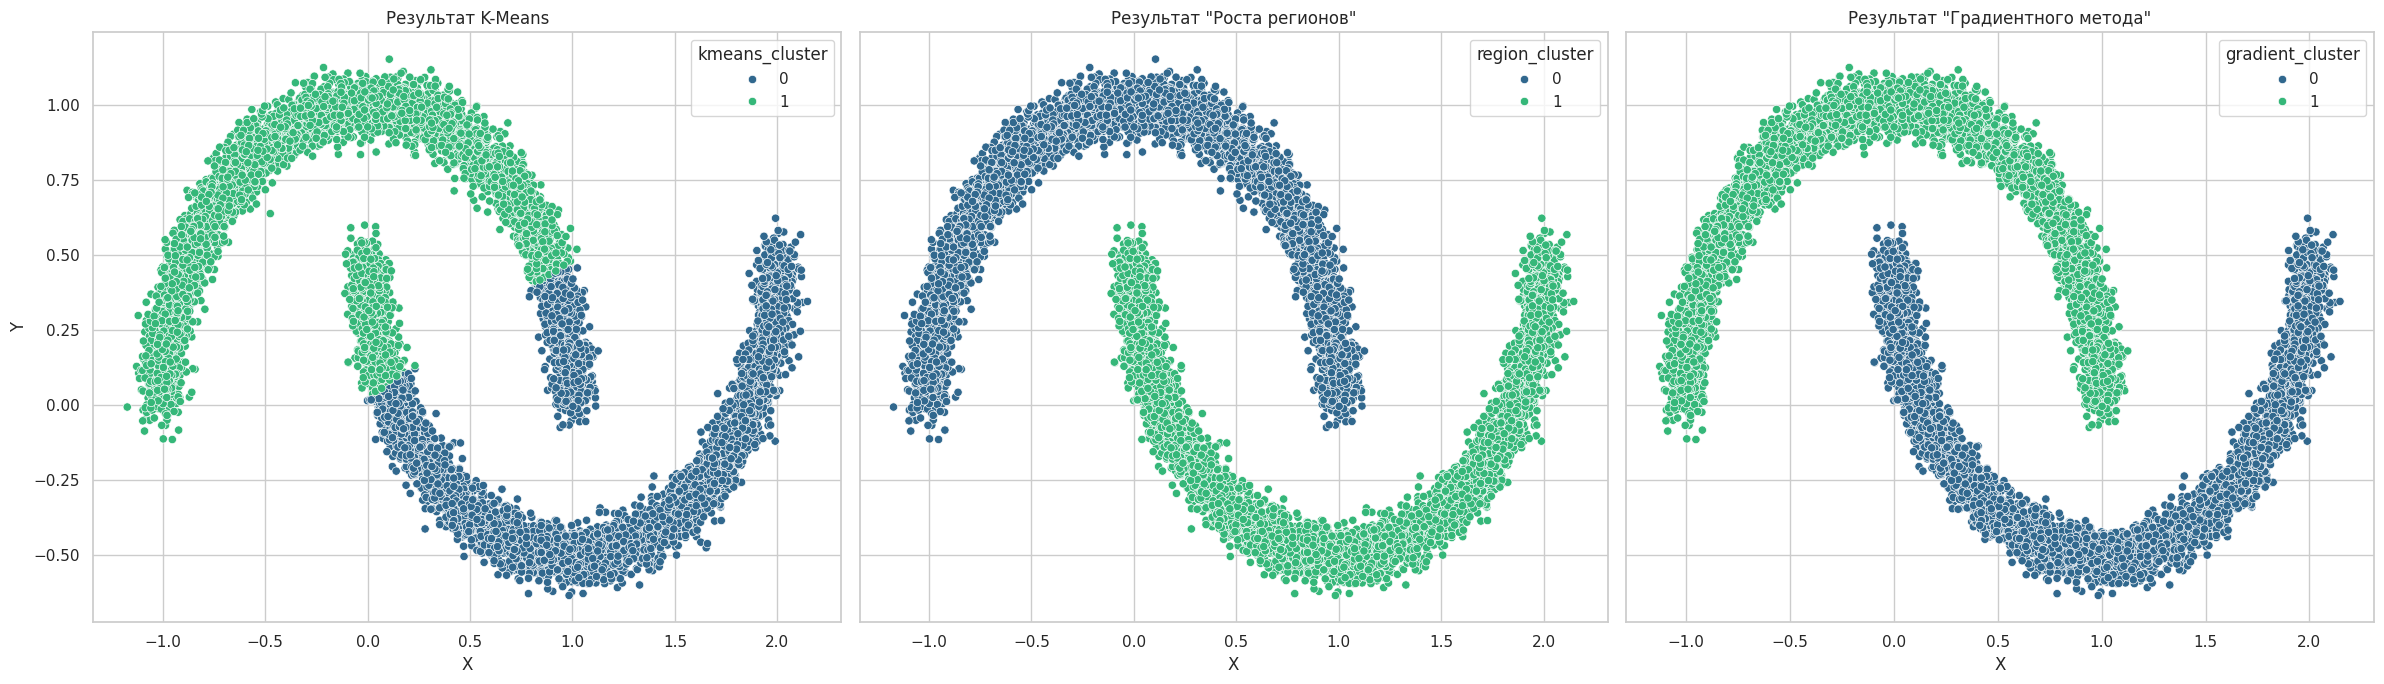

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)

sns.scatterplot(data=df2, x='X', y='Y', hue='kmeans_cluster', palette='viridis', ax=axes[0], legend='full')
axes[0].set_title('Результат K-Means')

sns.scatterplot(data=df2[df2['region_cluster'] != -1], x='X', y='Y', hue='region_cluster', palette='viridis', ax=axes[1], legend='full')
axes[1].set_title('Результат "Роста регионов"')

sns.scatterplot(data=df2[df2['gradient_cluster'] != -1], x='X', y='Y', hue='gradient_cluster', palette='viridis', ax=axes[2], legend='full')
axes[2].set_title('Результат "Градиентного метода"')

plt.tight_layout()
plt.show()

### Работа алгоритма на исходных данных


In [39]:
data = pd.read_excel("/content/DZ9.xlsx")

In [40]:
scaler_excel = MinMaxScaler()
data_normalized = pd.DataFrame(scaler_excel.fit_transform(data[['x', 'y']]), columns=['X', 'Y'])
data_normalized.head()

,X,Y
0,0.777540,0.657910
1,0.583291,0.393258
2,0.455277,0.167261
3,0.477965,0.280162
4,0.749217,0.800564


In [41]:
data['kmeans_cluster'] = run_kmeans(data_normalized, n_clusters=5) # Assuming 5 clusters based on the first dataset
labels_region, grid_region, peaks_region = run_region_growing(data_normalized)
data['region_cluster'] = labels_region
labels_gradient, grid_gradient, peaks_gradient = run_gradient_method(data_normalized)
data['gradient_cluster'] = labels_gradient

### Визуализация результатов для данных из файла DZ9.xlsx

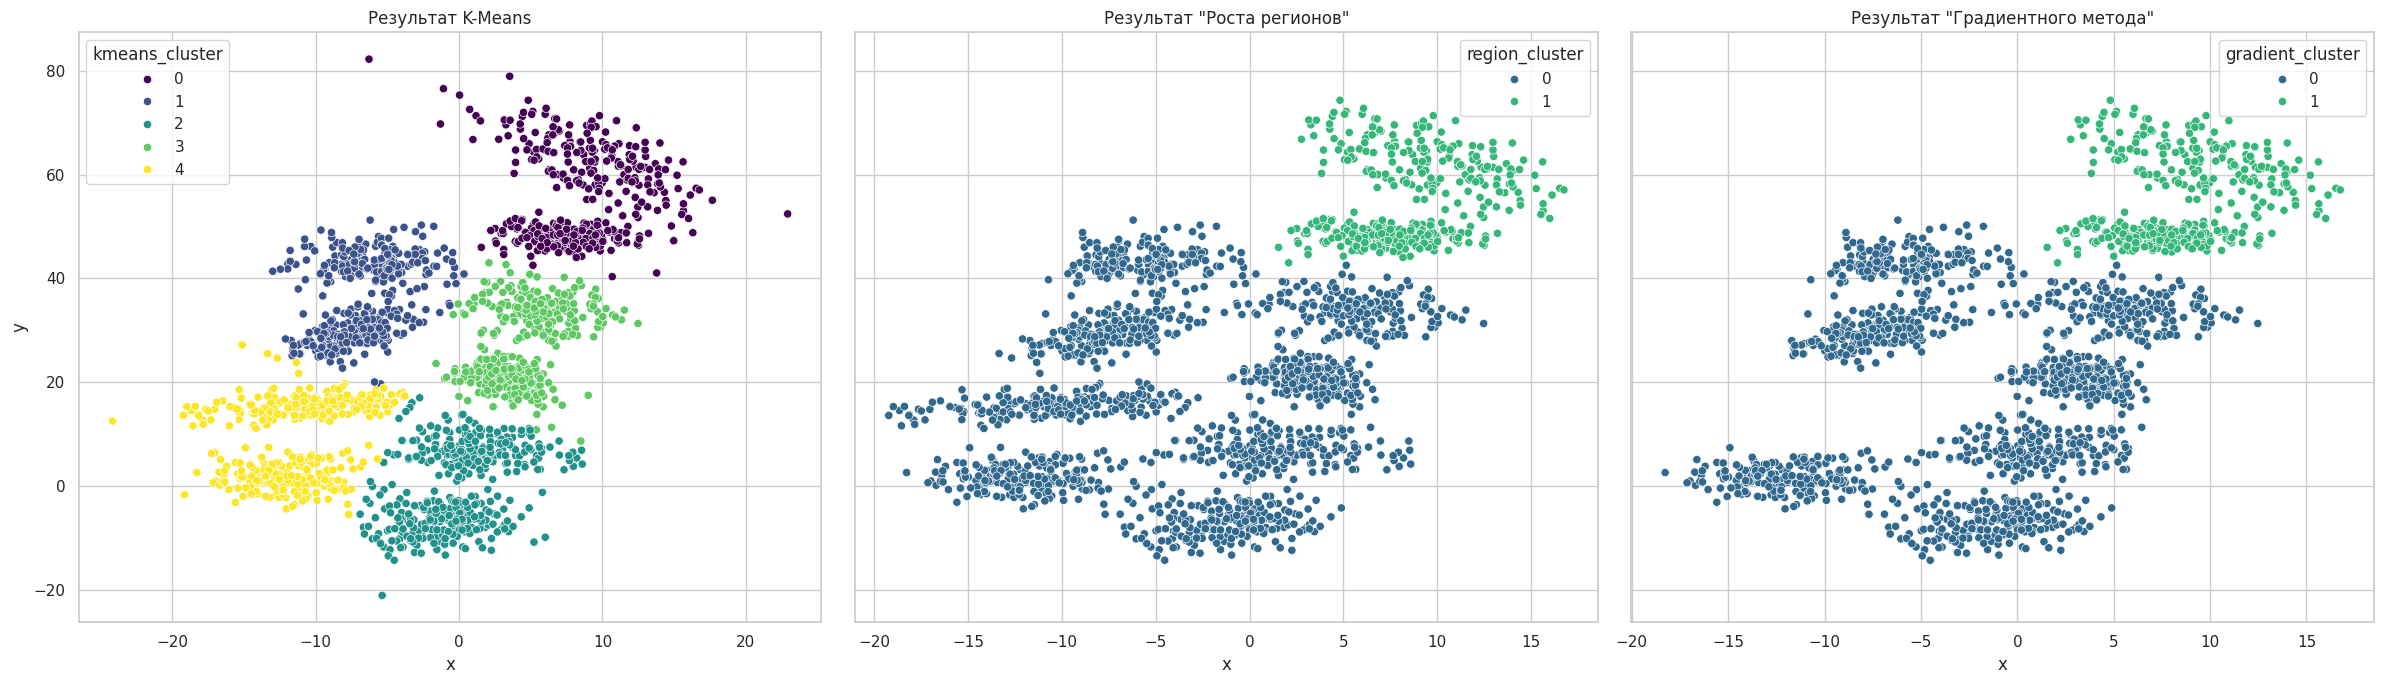

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)

sns.scatterplot(data=data, x='x', y='y', hue='kmeans_cluster', palette='viridis', ax=axes[0], legend='full')
axes[0].set_title('Результат K-Means')

sns.scatterplot(data=data[data['region_cluster'] != -1], x='x', y='y', hue='region_cluster', palette='viridis', ax=axes[1], legend='full')
axes[1].set_title('Результат "Роста регионов"')

sns.scatterplot(data=data[data['gradient_cluster'] != -1], x='x', y='y', hue='gradient_cluster', palette='viridis', ax=axes[2], legend='full')
axes[2].set_title('Результат "Градиентного метода"')

plt.tight_layout()
plt.show()

### Выводы

В зависимости от данных надо решать, какой алгоритм надо использовать